In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

In [186]:
ingredients_data_path = 'dataset/Pizza_ingredients.xlsx'
sales_data_path = 'dataset/Pizza_Sale.xlsx'

Sales_dataset = pd.read_excel(sales_data_path)
Ingredients_dataset = pd.read_excel(ingredients_data_path)

In [187]:
Sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [188]:
Sales_dataset.info()
Sales_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


In [189]:
Ingredients_dataset.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [190]:
Sales_dataset.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [191]:
Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1601218717.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)


In [192]:
Sales_dataset['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [193]:
Sales_dataset[Sales_dataset['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,2015-03-01 00:00:00,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,2015-03-01 00:00:00,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,2015-03-01 00:00:00,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,2015-03-01 00:00:00,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,2015-03-01 00:00:00,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [194]:
Sales_dataset['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [195]:
category_mapping = Sales_dataset[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name_id'].map(category_mapping))

In [196]:
Sales_dataset[Sales_dataset['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,2015-04-01 00:00:00,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,2015-05-01 00:00:00,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,2015-05-01 00:00:00,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [197]:
ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(ingredients_mapping))

In [198]:
Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,2015-05-01 00:00:00,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,2015-05-01 00:00:00,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [199]:
len(Sales_dataset['pizza_ingredients'].value_counts())

32

In [200]:
ingredients_name_mapping = Sales_dataset[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_dataset['pizza_name'] = Sales_dataset['pizza_name'].fillna(Sales_dataset['pizza_ingredients'].map(ingredients_name_mapping))

In [201]:
name_id_mapping = Sales_dataset[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales_dataset['pizza_name_id'] = Sales_dataset['pizza_name_id'].fillna(Sales_dataset['pizza_name'].map(name_id_mapping))

In [202]:
# Verifing the Changes
Sales_dataset.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

## Calculateing the Mean for each Pizza Name ID:

In [203]:
mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [204]:
Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [205]:
# Checking for remaining missing values in Items_Qty_In_Grams
remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [206]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [207]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [208]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [209]:
merged_data.shape

(267576, 15)

In [210]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [211]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [212]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [213]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [214]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [215]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [216]:
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [217]:
merged_data1 = merged_data.copy()

In [218]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [219]:
merged_data['day_of_week'] = merged_data['order_date'].dt.day_name()
merged_data['month'] = merged_data['order_date'].dt.month
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
merged_data['year'] = merged_data['order_date'].dt.year

In [220]:
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [221]:
pizza_sales = merged_data

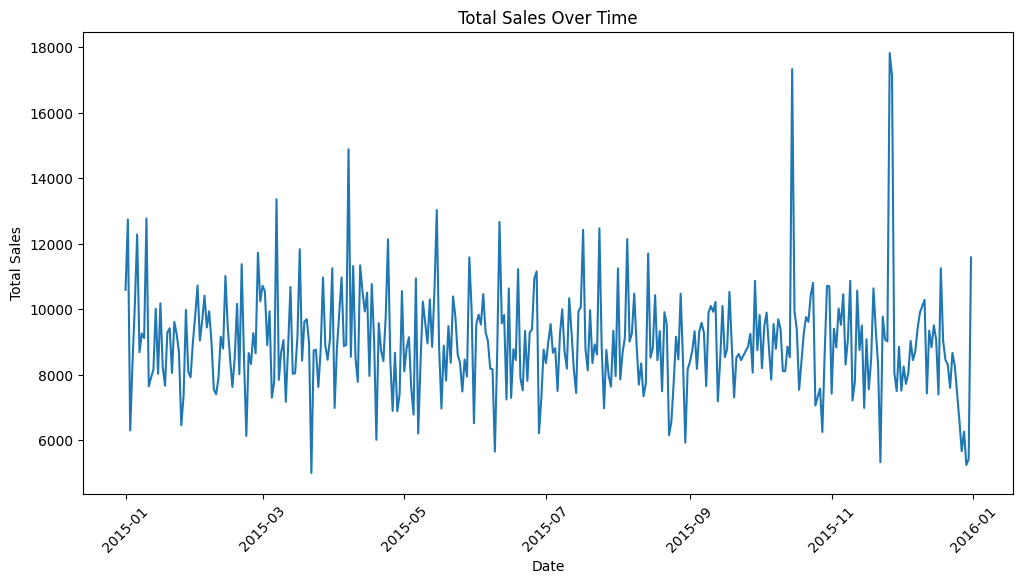

In [222]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

## Top-Selling Pizzas

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\317202510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')


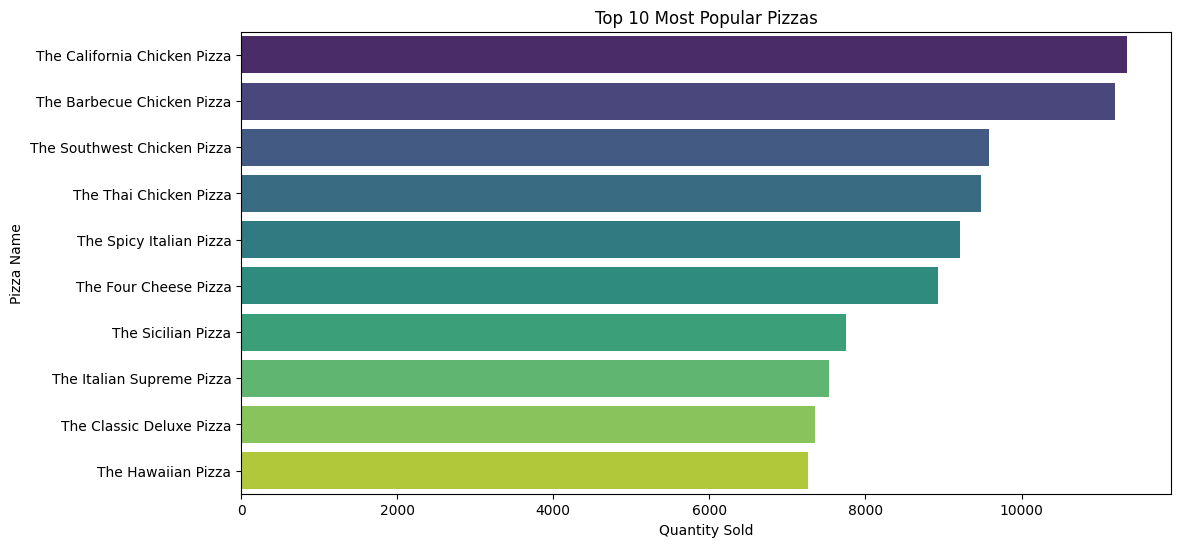

In [223]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

## Sales by Pizza Size and Category

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1902294798.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')


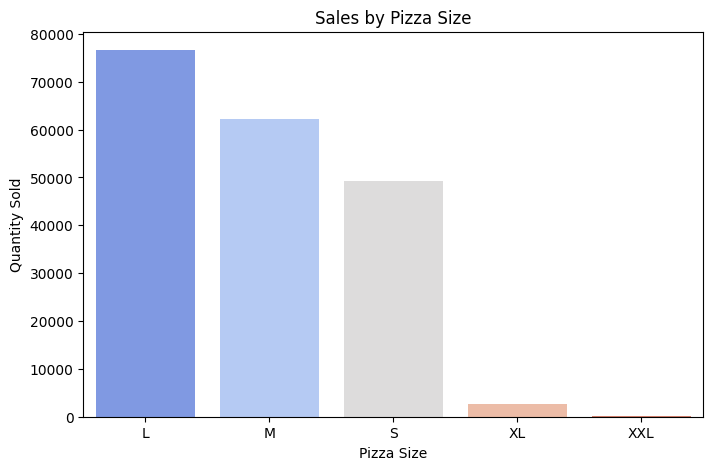

In [224]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\2067447341.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')


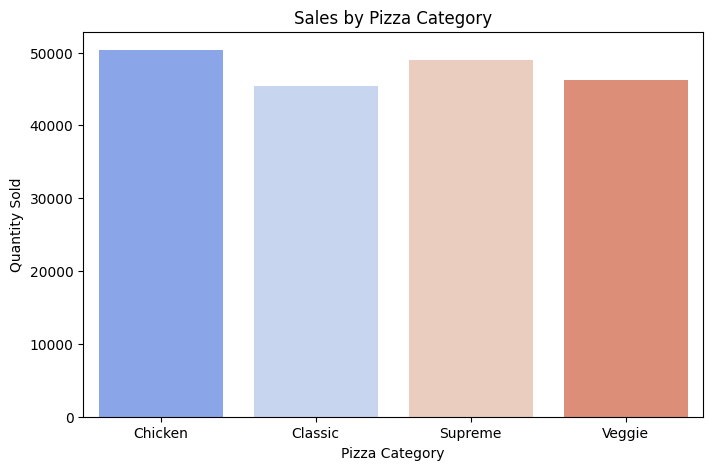

In [225]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

## Seasonal Sales Trends and Patterns

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\2922353652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')


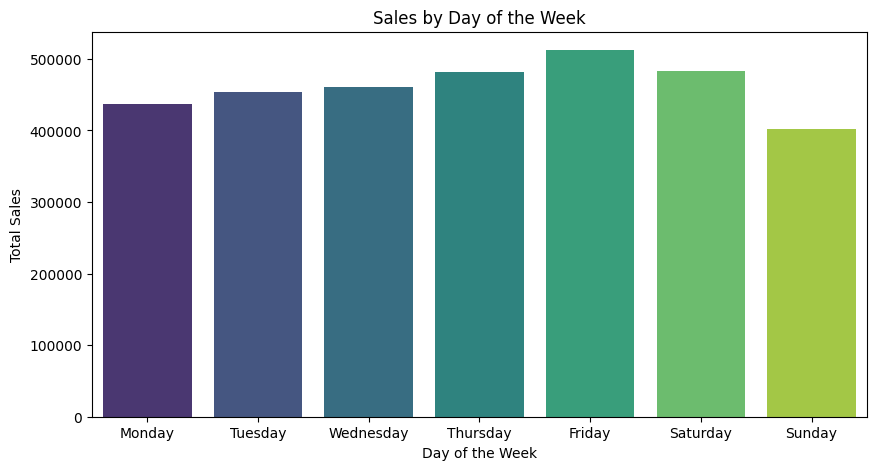

In [226]:
merged_data['day_of_week']= merged_data['order_date'].dt.day_name()
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

## Sales by Month

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\158514186.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')


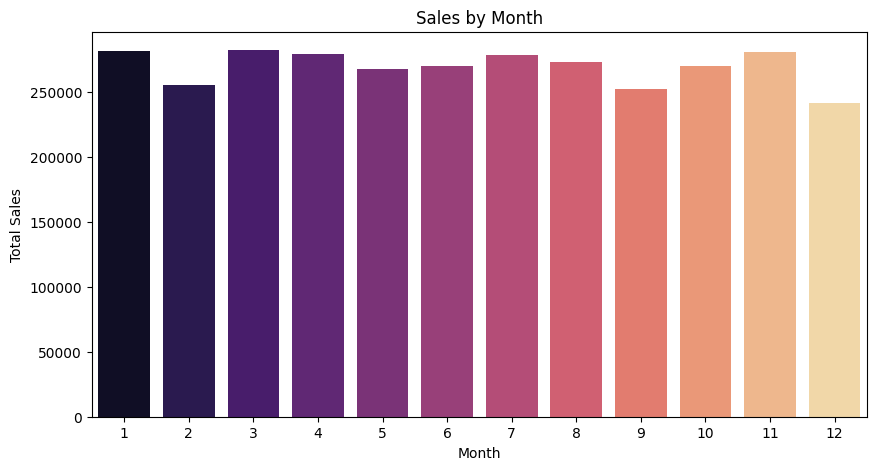

In [227]:
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [228]:
merged_data_1=merged_data[['order_date','pizza_name','quantity']]


In [229]:
merged_data_1

,order_date,pizza_name,quantity
0,2015-01-01,The Hawaiian Pizza,1
1,2015-01-01,The Hawaiian Pizza,1
2,2015-01-01,The Hawaiian Pizza,1
3,2015-01-01,The Classic Deluxe Pizza,1
6,2015-01-01,The Classic Deluxe Pizza,1
...,...,...,...
267565,2015-12-31,The Mexicana Pizza,1
267567,2015-12-31,The Mexicana Pizza,1
267570,2015-12-31,The Barbecue Chicken Pizza,1
267571,2015-12-31,The Barbecue Chicken Pizza,1


In [230]:
import pandas as pd

merged_data_1['order_date'] = pd.to_datetime(merged_data_1['order_date'])

merged_data_1['week_day'] = merged_data_1['order_date'].dt.day_name()

merged_data_1['is_holiday'] = merged_data_1['week_day'].isin(['Saturday', 'Sunday'])

merged_data_1['is_promotional_day'] = merged_data_1['week_day'].isin(['Tuesday'])
merged_data_1.drop(columns=['week_day'],inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\2351630888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_1['order_date'] = pd.to_datetime(merged_data_1['order_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\2351630888.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_1['week_day'] = merged_data_1['order_date'].dt.day_name()
C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\2351630888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [231]:
mapes=[]
models=[]

# ARIMA Model
* p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
* d (Differencing term): The number of times the data is differenced to make it stationary.
* q (Moving Average term): The number of past forecast errors used to improve future predictions.

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:47

Best ARIMA Model MAPE: 0.1980, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3458.636971
2015-10-26    3842.275023
2015-11-02    3625.607216
2015-11-09    3652.163767
2015-11-16    3560.002618
2015-11-23    3871.627560
2015-11-30    3525.796405
2015-12-07    3668.202270
2015-12-14    3652.301661
2015-12-21    3813.710711
2015-12-28    3460.012227
Name: predicted_mean, dtype: float64


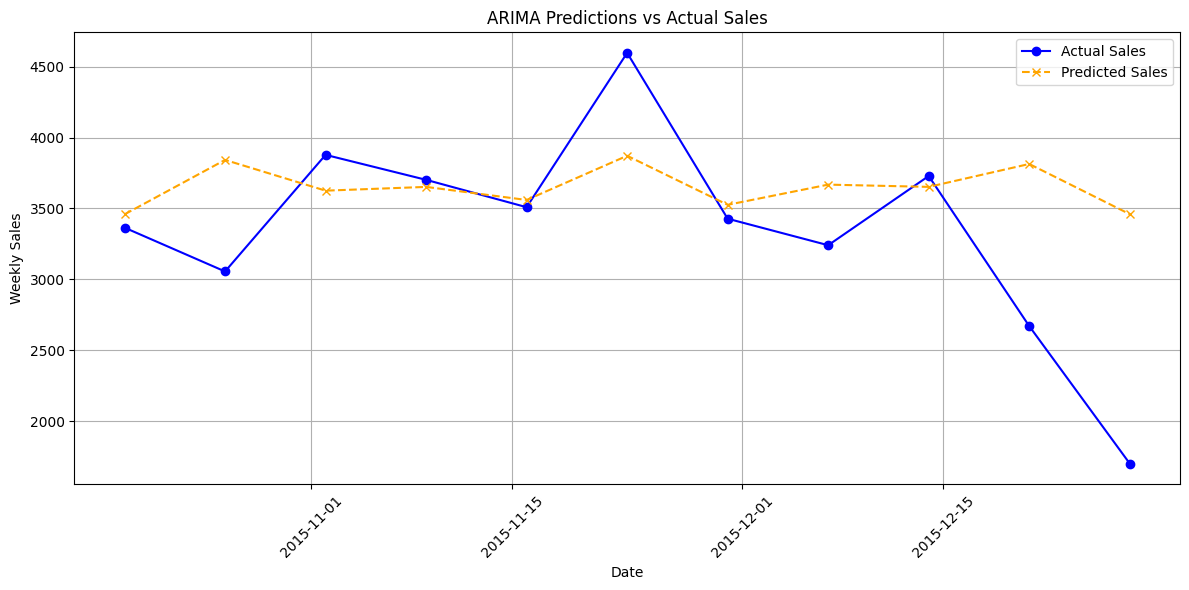

In [232]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data)

train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue
    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)
models.append('ARIMA')
mapes.append(arima_mape_score)

arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# SARIMA (Seasonal ARIMA)
* P (Seasonal AutoRegressive term): The number of past seasonal values used for prediction.
* D (Seasonal Differencing term): The number of seasonal differencing applied to make data stationary.
* Q (Seasonal Moving Average term): The number of past seasonal forecast errors used for prediction.
* S (Seasonal Period): The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1007188377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible startin

Best SARIMA Model MAPE: 0.2327
Predictions:
order_date
2015-10-19    3639.064911
2015-10-26    3962.060813
2015-11-02    3803.567950
2015-11-09    3536.255621
2015-11-16    3700.833924
2015-11-23    3810.493786
2015-11-30    3827.372011
2015-12-07    3746.217253
2015-12-14    4015.172832
2015-12-21    3866.686552
2015-12-28    3566.403132
Name: predicted_mean, dtype: float64


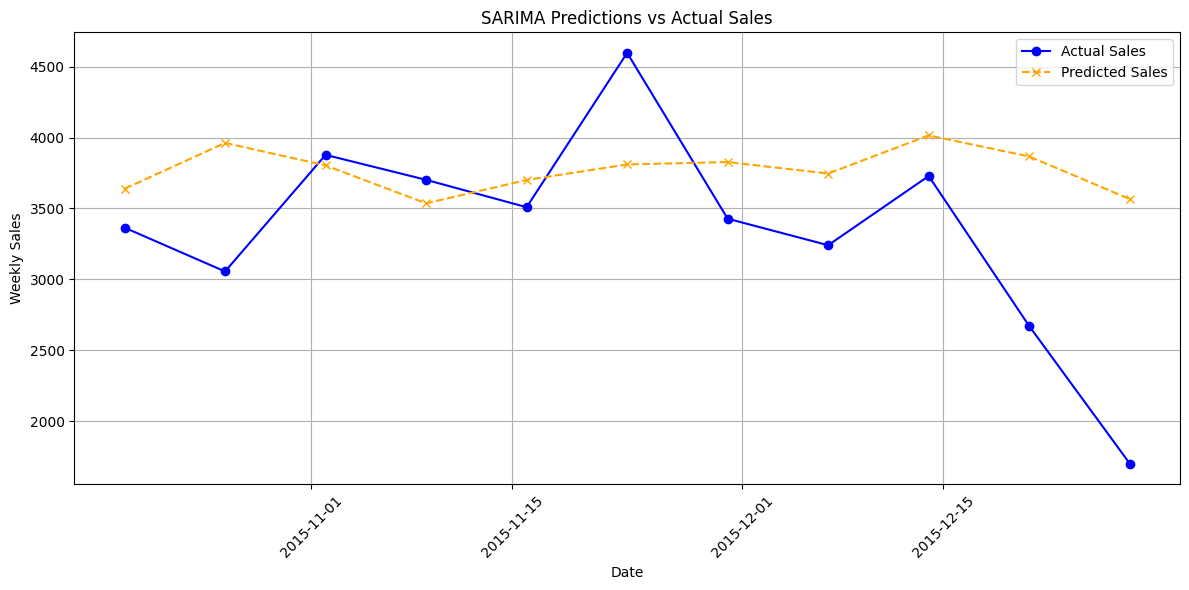

In [233]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data_1)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)
models.append('SARIMA')
mapes.append(sarima_mape_score)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Prophet (Developed by Facebook)
### Prophet is a popular model for handling time series data with seasonal and holiday effects.
The Facebook Prophet model is a tool developed by Facebook for forecasting time series data. It’s especially useful when you want to predict future values based on historical data, such as sales, temperatures, or website traffic.
* Growth: Defines the trend type (linear or logistic).
* Changepoints: Points where the trend changes.
* Seasonality: Models seasonal patterns (weekly, yearly, etc.).
* Holidays: Incorporates custom holidays or events affecting the forecast.
* Seasonality Mode: Can be additive or multiplicative.

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\951125341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])
11:52:03 - cmdstanpy - INFO - Chain [1] start processing
11:52:03 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.2163
Predictions:
ds
2015-10-19    3684.955697
2015-10-26    3685.691317
2015-11-02    3686.426937
2015-11-09    3687.162557
2015-11-16    3687.898177
2015-11-23    3688.633796
2015-11-30    3689.369416
2015-12-07    3690.105036
2015-12-14    3690.840656
2015-12-21    3691.576276
2015-12-28    3692.311896
dtype: float64


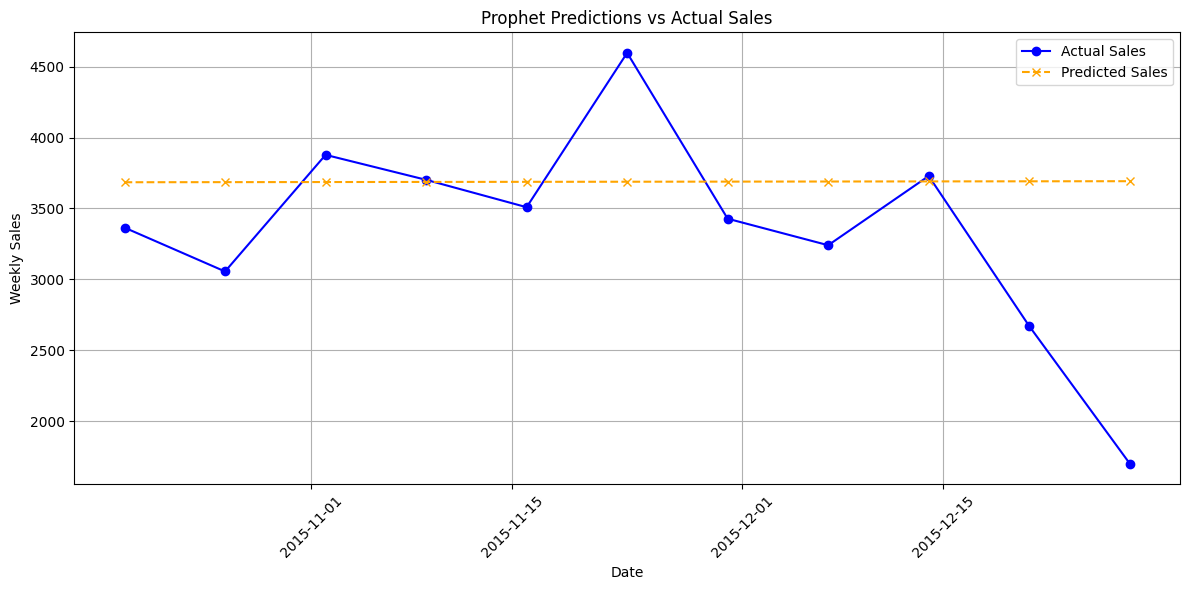

In [234]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(merged_data_1)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)
models.append('PROPHET')
mapes.append(prophet_mape_score)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## LSTM model

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1105349152.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])


1/1 [==============================] - 0s 160ms/step
Best LSTM Model MAPE: 0.2270
Predictions:
order_date
2015-11-09    3458.531738
2015-11-16    3540.304443
2015-11-23    3662.409668
2015-11-30    3819.357910
2015-12-07    3772.878662
2015-12-14    3724.256348
2015-12-21    3484.524170
2015-12-28    3325.091553
dtype: float32


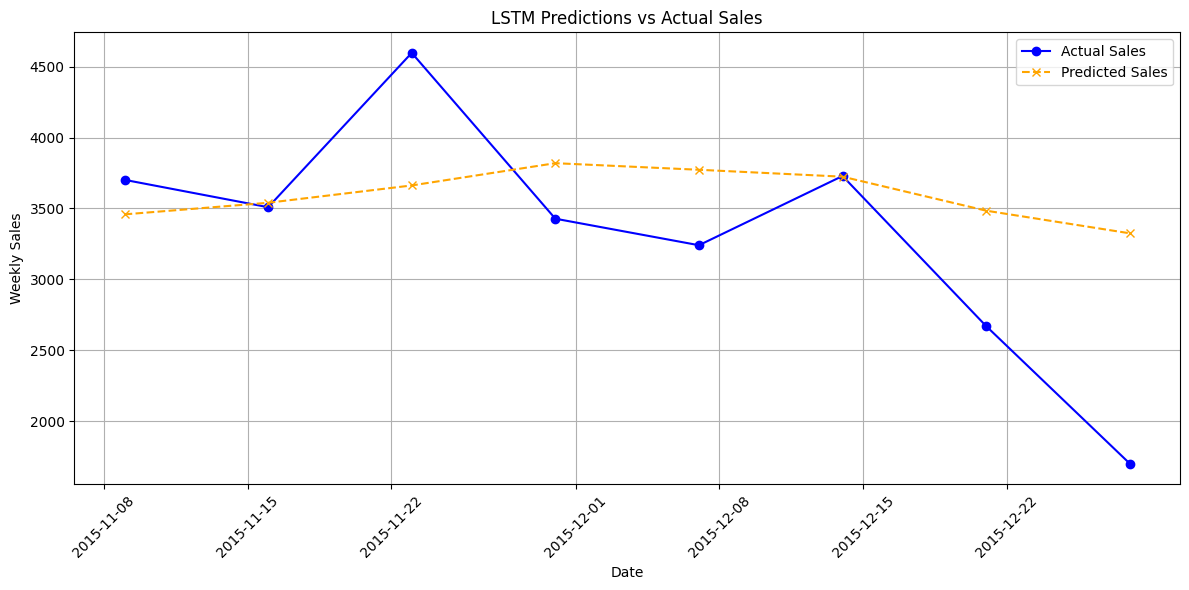

In [235]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_data_1)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)
models.append('LSTM')
mapes.append(lstm_mape_score)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### SARIMAX Model Components:

1. **p**:  - AutoRegressive term (number of past observations used to predict future values).

2. **d**:  - Differencing term (number of times data is differenced to achieve stationarity).

3. **q**:  - Moving Average term (number of past forecast errors included).

4. **P**:  - Seasonal AutoRegressive term (number of seasonal lags used).

5. **D**:  - Seasonal Differencing term (number of seasonal differencing operations).

6. **Q**:  - Seasonal Moving Average term (number of seasonal forecast errors).

7. **m**:  - Seasonal Periodicity (number of time steps per season, e.g., `7` for weekly seasonality).

8. **Exogenous Variables**:  - External factors (e.g., `is_holiday`, `is_promotional_day`) influencing the target variable.



C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1633611424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\1633611424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_start'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided

Best SARIMAX Model MAPE: 0.1903
Predictions:
week_start
2015-10-19    3701.923867
2015-10-26    3800.070097
2015-11-02    3567.319308
2015-11-09    3906.105974
2015-11-16    3297.338453
2015-11-23    3599.587411
2015-11-30    3353.974458
2015-12-07    3658.020313
2015-12-14    3736.894200
2015-12-21    3599.302308
2015-12-28    3126.044093
Name: predicted_mean, dtype: float64


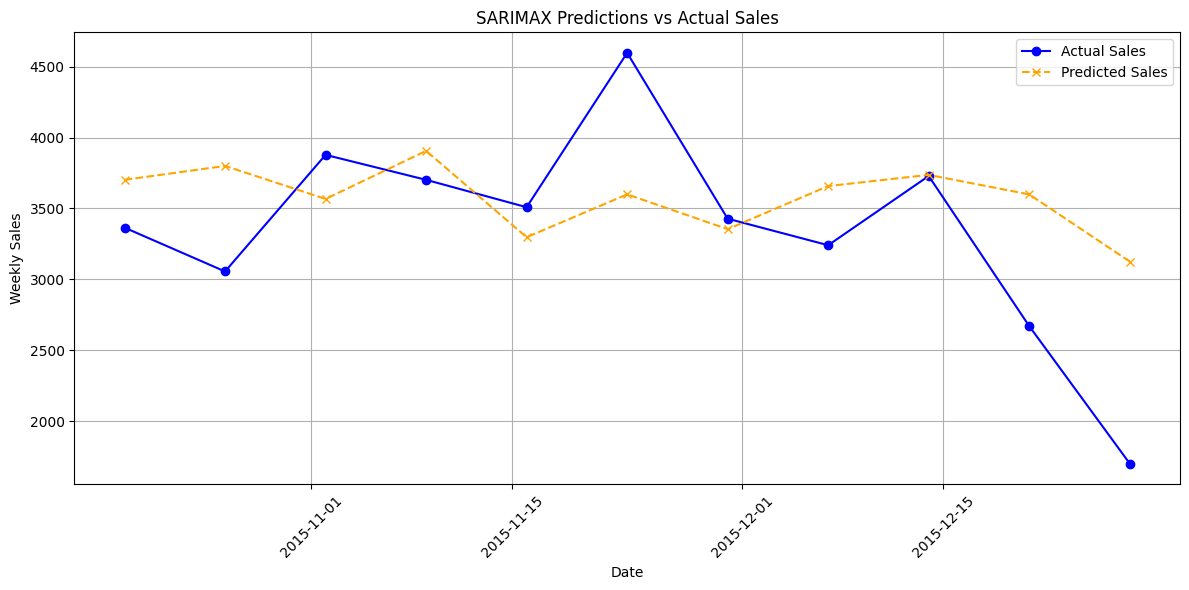

In [236]:
# Preparing weekly sales with exogenous variables
def prepare_weekly_sales_with_exogenous(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week_start'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales = df.groupby('week_start').agg({
        'quantity': 'sum', 
        'is_holiday': 'max', 
        'is_promotional_day': 'max'
    })
    # Convert boolean columns to numeric
    weekly_sales['is_holiday'] = weekly_sales['is_holiday'].astype(int)
    weekly_sales['is_promotional_day'] = weekly_sales['is_promotional_day'].astype(int)
    return weekly_sales

# Prepare the data
pizza_sales_weekly_exog = prepare_weekly_sales_with_exogenous(merged_data_1)

# Splitting the data into train and test
train_size = int(0.8 * len(pizza_sales_weekly_exog))
train, test = pizza_sales_weekly_exog.iloc[:train_size], pizza_sales_weekly_exog.iloc[train_size:]

# Separating sales (endogenous) and exogenous variables
train_sales, train_exog = train['quantity'], train[['is_holiday', 'is_promotional_day']]
test_sales, test_exog = test['quantity'], test[['is_holiday', 'is_promotional_day']]

# MAPE calculation
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMAX Model Training and Output
def best_sarimax_model(train_sales, train_exog, test_sales, test_exog):
    model = SARIMAX(train_sales, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test_sales), exog=test_exog)
    sarimax_mape = mape(test_sales, predictions)

    print(f"Best SARIMAX Model MAPE: {sarimax_mape:.4f}")
    return predictions, sarimax_mape

# Train and evaluate the SARIMAX model
sarimax_predictions, sarimax_mape_score = best_sarimax_model(train_sales, train_exog, test_sales, test_exog)
models.append('SARIMAX')
mapes.append(sarimax_mape_score)

# Formatting the predictions for display
sarimax_predictions = pd.Series(sarimax_predictions, index=test.index)

print("Predictions:")
print(sarimax_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test_sales.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarimax_predictions.index, sarimax_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMAX Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [237]:
import pandas as pd

model_performance = {'Model': models, 'MAPE': mapes}
# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
4,SARIMAX,0.190251,1.0,Best
0,ARIMA,0.197966,2.0,
2,PROPHET,0.216333,3.0,
3,LSTM,0.226969,4.0,
1,SARIMA,0.232714,5.0,Worst


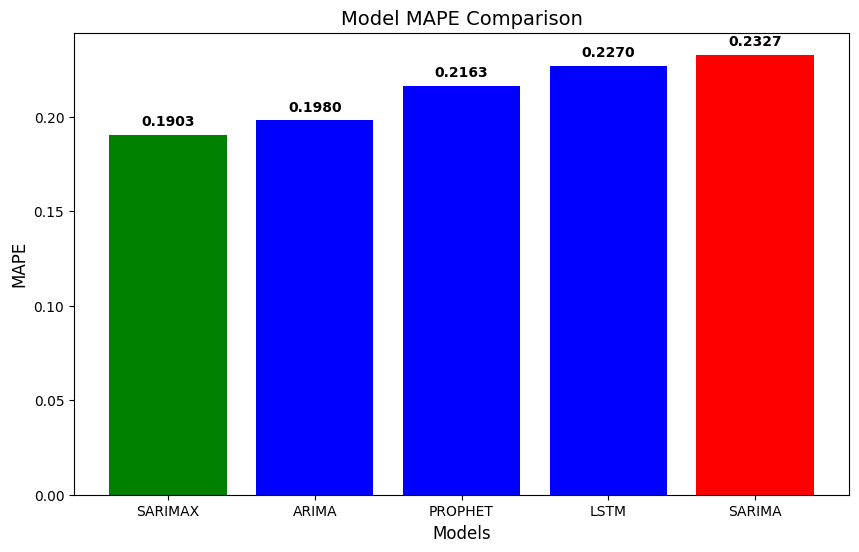

In [238]:
import matplotlib.pyplot as plt

# Sort models and corresponding mapes in ascending order
sorted_indices = sorted(range(len(mapes)), key=lambda i: mapes[i])
sorted_models = [models[i] for i in sorted_indices]
sorted_mapes = [mapes[i] for i in sorted_indices]
colors = ['green', 'blue', 'blue','blue', 'red']

# Plotting with ordered colors
plt.figure(figsize=(10,6))
plt.bar(sorted_models, sorted_mapes, color=colors)

plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(sorted_mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()


## SARIMAX Evaluation

In [239]:
sarimax_model = SARIMAX(train_sales, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
print(sarimax_model.summary())

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -242.820
Date:                           Sat, 21 Dec 2024   AIC                            499.641
Time:                                   11:52:36   BIC                            510.325
Sample:                               12-29-2014   HQIC                           503.285
                                    - 10-12-2015                                         
Covariance Type:                             opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
is_holiday            37.9925   3426.825      0.011      0.991   -6678.462    6754.447
is_promotional_day 

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Hyperparameter Tuning for SARIMAX

In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

# Define parameter grids
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
seasonal_order = range(0, 8)  # m = 7 for weekly data

# Prepare combinations
param_combinations = list(product(p, d, q, P, D, Q, [7]))

# Function to evaluate model
def evaluate_model(params):
    p, d, q, P, D, Q, s = params
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Suppress warnings
        try:
            model = SARIMAX(train_sales, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=False)
            predictions = model.forecast(steps=len(test_sales), exog=test_exog)
            mape_score = mape(test_sales, predictions)
            return model.aic, mape_score
        except Exception as e:
            return float('inf'), float('inf')

# Perform grid search
results = []
for params in param_combinations:
    aic, mape = evaluate_model(params)
    results.append((params, aic, mape))

# Sort results based on AIC
results.sort(key=lambda x: x[1])

# Best SARIMAX model
best_params, best_aic, best_mape = results[0]
print(f"Best Parameters: {best_params}, AIC: {best_aic}, MAPE: {best_mape:.4f}")


# Fit best model
best_sarimax_model = SARIMAX(train_sales, exog=train_exog, order=best_params[:3], seasonal_order=best_params[3:]).fit(disp=False)
print(best_sarimax_model.summary())


Best Parameters: (0, 0, 0, 0, 0, 0, 7), AIC: 595.3593737523564, MAPE: 0.1245
                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   42
Model:                        SARIMAX   Log Likelihood                -294.680
Date:                Sat, 21 Dec 2024   AIC                            595.359
Time:                        11:57:39   BIC                            600.572
Sample:                    12-29-2014   HQIC                           597.270
                         - 10-12-2015                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
is_holiday          2247.9998   4.26e+08   5.28e-06      1.000   -8.34e+08    8.34e+08
is_promotional_day  1455.7315 

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


## Saving the Model Using pickle

In [241]:
import pickle

model_filename = 'best_sarimax_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(sarimax_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_sarimax_model.pkl


# 10. Final Results and Predictions

In [242]:
# Loading the model
model_filename = 'best_sarimax_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)


## Forecasting Report Visulazation

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Admin\AppData\Local\Temp\ipykernel_1732


SARIMAX Forecasted sales for the week 2016-01-04 to 2016-01-10:
Total quantity: 3739 pizzas


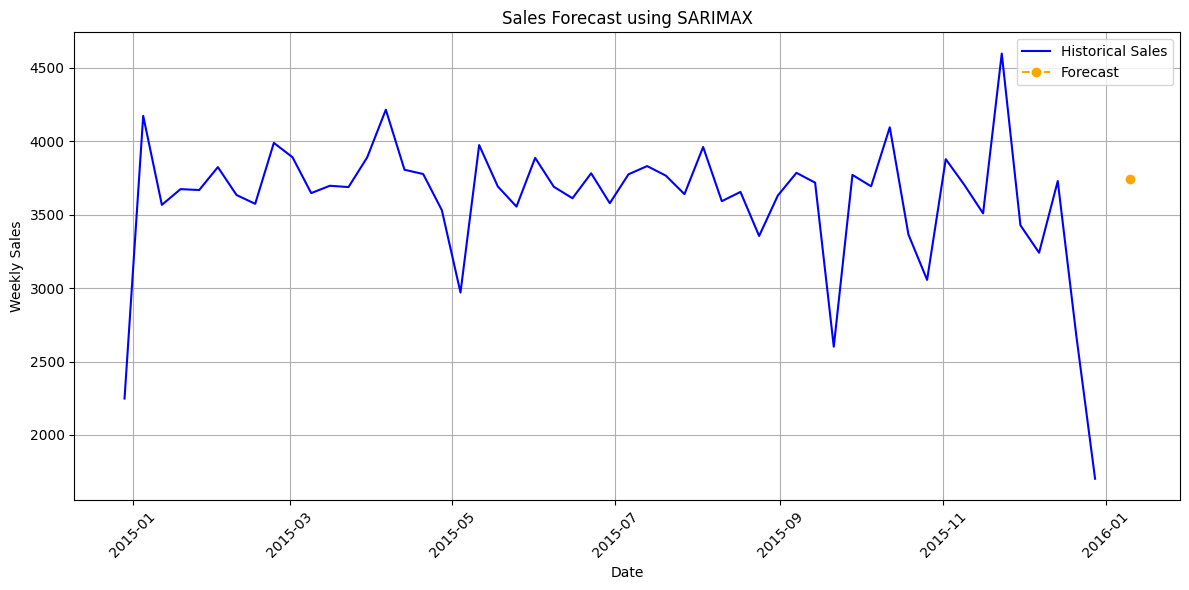

In [243]:
# Function to forecast next week's sales using SARIMAX with exogenous variables
def forecast_next_week_sales_sarimax(pizza_sales_weekly_exog, periods=1):
    # Get the last week in the dataset
    last_week = pizza_sales_weekly_exog.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)
    
    # Prepare training data
    train_size = int(0.8 * len(pizza_sales_weekly_exog))
    train = pizza_sales_weekly_exog.iloc[:train_size]
    
    # Separate endogenous and exogenous variables
    train_sales = train['quantity']
    train_exog = train[['is_holiday', 'is_promotional_day']]
    

    forecast_exog = pd.DataFrame({
        'is_holiday': [2],
        'is_promotional_day': [1] 
    })
    
    try:
        # Fit SARIMAX model
        model = SARIMAX(
            train_sales,
            exog=train_exog,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7)
        ).fit(disp=False)
        
        # Generate forecast
        forecast = model.forecast(steps=periods, exog=forecast_exog)
        
        return forecast, next_week_start, next_week_end
        
    except Exception as e:
        print(f"Forecast failed: {str(e)}")
        return None, next_week_start, next_week_end

# Generate the forecast
next_week_forecast_sarimax, next_week_start, next_week_end = forecast_next_week_sales_sarimax(
    pizza_sales_weekly_exog,
    periods=1
)

if next_week_forecast_sarimax is not None:
    # Round the forecast to whole numbers
    forecasted_quantity = int(next_week_forecast_sarimax[0])
    
    print(f"\nSARIMAX Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
    print(f"Total quantity: {forecasted_quantity} pizzas")
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(
        pizza_sales_weekly_exog.index,
        pizza_sales_weekly_exog['quantity'],
        label='Historical Sales',
        color='blue'
    )
    
    # Plot forecast
    forecast_index = pd.date_range(start=next_week_start, periods=1, freq='W')
    plt.plot(
        forecast_index,
        next_week_forecast_sarimax,
        label='Forecast',
        color='orange',
        linestyle='--',
        marker='o'
    )
    
    plt.title('Sales Forecast using SARIMAX')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [244]:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_data_1)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\280728861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_17324\280728861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

Forecasted sales for the week 2016-01-04 to 2016-01-10:
The Barbecue Chicken Pizza: 189 pizzas
The Big Meat Pizza: 102 pizzas
The Brie Carre Pizza: 46 pizzas
The Calabrese Pizza: 55 pizzas
The California Chicken Pizza: 195 pizzas
The Chicken Alfredo Pizza: 90 pizzas
The Chicken Pesto Pizza: 71 pizzas
The Classic Deluxe Pizza: 131 pizzas
The Five Cheese Pizza: 47 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 164 pizzas
The Green Garden Pizza: 97 pizzas
The Hawaiian Pizza: 121 pizzas
The Italian Capocollo Pizza: 134 pizzas
The Italian Supreme Pizza: 119 pizzas
The Italian Vegetables Pizza: 92 pizzas
The Mediterranean Pizza: 84 pizzas
The Mexicana Pizza: 110 pizzas
The Napolitana Pizza: 113 pizzas
The Pepper Salami Pizza: 127 pizzas
The Pepperoni Pizza: 91 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 35 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 113 pizzas
The Soppressata Pizza: 73 pizzas
The Southwest Chicken Pizza: 215 pizzas
The Spicy Itali

c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\miniconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [245]:
ingredients_predicted = Ingredients_dataset
predicted_quantity_map = next_week_pizza_sales_forecasts 

ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name'].map(predicted_quantity_map)

ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()

print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted


Total quantity of predicted ingredients for the following week:
{'?duja Salami': 6600.0, 'Alfredo Sauce': 4050.0, 'Anchovies': 9605.0, 'Artichokes': 29520.0, 'Arugula': 2130.0, 'Asiago Cheese': 17520.0, 'Bacon': 50670.0, 'Barbecue Sauce': 5670.0, 'Barbecued Chicken': 17010.0, 'Beef Chuck Roast': 93480.0, 'Blue Cheese': 1410.0, 'Brie Carre Cheese': 1380.0, 'Calabrese Salami': 35700.0, 'Capocollo': 160200.0, 'Caramelized Onions': 736.0, 'Chicken': 219600.0, 'Chipotle Sauce': 19500.0, 'Chorizo Sausage': 5100.0, 'Cilantro': 9750.0, 'Coarse Sicilian Salami': 27120.0, 'Corn': 65000.0, 'Eggplant': 11040.0, 'Feta Cheese': 54810.0, 'Fontina Cheese': 16080.0, 'Friggitello Peppers': 1650.0, 'Garlic': 71955.0, 'Genoa Salami': 22860.0, 'Goat Cheese': 34560.0, 'Gorgonzola Piccante Cheese': 12840.0, 'Gouda Cheese': 11700.0, 'Green Olives': 13260.0, 'Green Peppers': 22330.0, 'Italian Sausage': 1020.0, 'Jalapeno Peppers': 15600.0, 'Kalamata Olives': 17070.0, 'Luganega Sausage': 13560.0, 'Mozzarella Che

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,189,7560.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,189,2835.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,189,3780.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,189,5670.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,189,11340.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,182,3640.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,182,3640.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,182,1820.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,182,2730.0


In [246]:
ingredient_totals

{'?duja Salami': 6600.0,
 'Alfredo Sauce': 4050.0,
 'Anchovies': 9605.0,
 'Artichokes': 29520.0,
 'Arugula': 2130.0,
 'Asiago Cheese': 17520.0,
 'Bacon': 50670.0,
 'Barbecue Sauce': 5670.0,
 'Barbecued Chicken': 17010.0,
 'Beef Chuck Roast': 93480.0,
 'Blue Cheese': 1410.0,
 'Brie Carre Cheese': 1380.0,
 'Calabrese Salami': 35700.0,
 'Capocollo': 160200.0,
 'Caramelized Onions': 736.0,
 'Chicken': 219600.0,
 'Chipotle Sauce': 19500.0,
 'Chorizo Sausage': 5100.0,
 'Cilantro': 9750.0,
 'Coarse Sicilian Salami': 27120.0,
 'Corn': 65000.0,
 'Eggplant': 11040.0,
 'Feta Cheese': 54810.0,
 'Fontina Cheese': 16080.0,
 'Friggitello Peppers': 1650.0,
 'Garlic': 71955.0,
 'Genoa Salami': 22860.0,
 'Goat Cheese': 34560.0,
 'Gorgonzola Piccante Cheese': 12840.0,
 'Gouda Cheese': 11700.0,
 'Green Olives': 13260.0,
 'Green Peppers': 22330.0,
 'Italian Sausage': 1020.0,
 'Jalapeno Peppers': 15600.0,
 'Kalamata Olives': 17070.0,
 'Luganega Sausage': 13560.0,
 'Mozzarella Cheese': 29190.0,
 'Mushrooms':

In [247]:
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


<Figure size 1200x800 with 0 Axes>

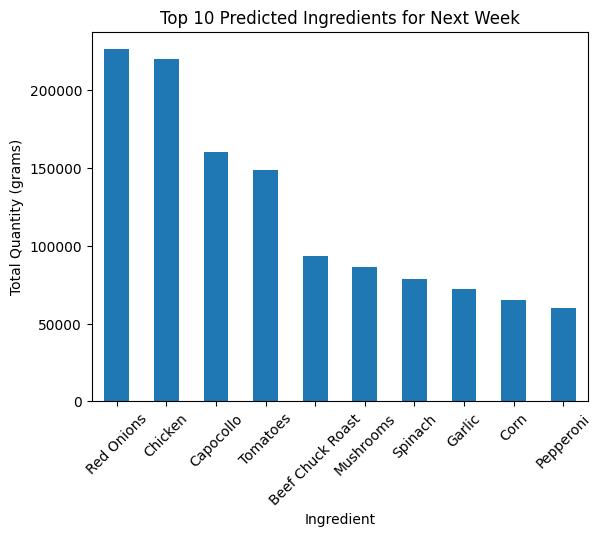

In [248]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(12, 8))
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(kind='bar', x='Ingredient', y='Total Quantity (grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()

In [249]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,6600.0
1,Alfredo Sauce,4050.0
2,Anchovies,9605.0
3,Artichokes,29520.0
4,Arugula,2130.0
...,...,...
59,Sun-dried Tomatoes,4200.0
60,Thai Sweet Chilli Sauce,9660.0
61,Thyme,230.0
62,Tomatoes,148380.0
